In [7]:
# Import libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import tqdm
import time
import requests
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error

In [25]:
!conda install python-graphviz --yes

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::resampy==0.2.2=py_0
  - conda-forge/noarch::librosa==0.7.2=py_1
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.36.0             |       h3371d22_4         560 KB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    cairo-1.16.0               |    ha61ee94_1011         1.5 MB  conda-forge
    certifi-2022.6.15          |   py39hf3d152e_0         155 KB  con

In [8]:
# !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip
# !unzip ukiyoe2photo.zip

In [9]:
def load_rescale(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.keras.layers.Rescaling(1./127.5, offset=-1)(image)
    return image


In [10]:
train_dataset = tf.data.Dataset.list_files('ukiyoe2photo/trainA/*.jpg') \
                                                .map(load_rescale,num_parallel_calls=tf.data.AUTOTUNE) \
                                                .shuffle(100) \
                                                .batch(1)

2022-07-28 06:07:09.653711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 06:07:09.653753: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 06:07:09.653779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-07-28 06:07:09.654106: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


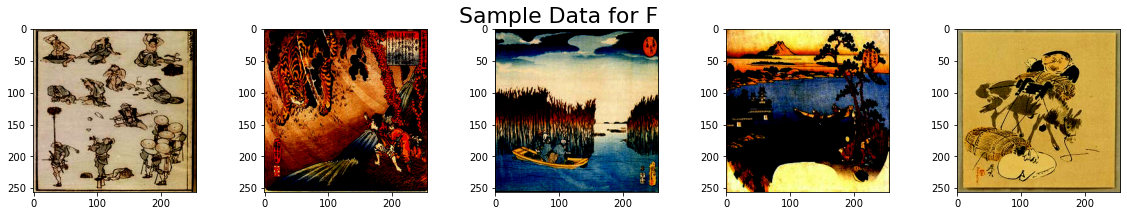

In [11]:
# Having a quick look at a few sample 
fig,ax = plt.subplots(1,5,figsize=(20,3))
fig.suptitle('Sample Data for F',fontsize=22)
i = 0
for img in train_dataset.take(5):
  ax[i].imshow(img[0])
  i += 1
plt.show()

The 70 × 70 discriminator architecture is:
C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

#### All networks were trained from scratch, and trained with learning rate of 0.0002 
#### for the first 100 epochs and linearly decaying rate to zero for the next 100 epochs. 
#### Weights were initialized from a Gaussian distribution with mean 0 and standard deviation 0.02.

In [12]:
# Your code here
d_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
initializer= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_discriminator(input_dim,leaky_alpha=0.2):
    inputs= layers.Input(input_dim)    
    x=layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(inputs)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    output=layers.Conv2D(1,(4,4),strides=(1,1),activation='sigmoid',padding='same')(x)


    model_disc=Model(inputs,output)
    model_disc.compile(loss=d_loss,optimizer=d_optimizer,metrics=['accuracy'])
    return model_disc


In [13]:
build_discriminator((256,256,3),leaky_alpha=0.2).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

In [14]:
p=0
k=4
s=2
o=1
for s in [1,1,2,2,2]:#[256,128,64,32,16]:
    n=(o-1)*s + k -2*p
    o=n
    print(i,n)

5 4
5 7
5 16
5 34
5 70


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

### 1) Let c7s1-k denote a 7 × 7 Convolution-BatchNorm-ReLU layer with k filters and stride 1. 

### 2) dk denotes a 3 × 3 Convolution-BatchNorm-Dropout-ReLU layer with k filters, and stride 2. 

### 3) Reflection padding was used to reduce artifacts. 

### 4) Rk denotes a residual block that contains two 3×3 convolutional layers with the same number of filters on both layer.

### 5) uk denotes a 3 × 3 fractional-strided-Convolution-BatchNorm-Dropout-ReLU layer with k filters, and stride 1/2 .

The network with 9 blocks consists of:
### c7s1-32, d64, d128, R128, R128, R128, R128, R128, R128, R128, R128, R128, u64, u32, c7s1-3

In [15]:
for i in train_dataset.take(1): plt

In [27]:
# g_loss= # new loss
g_optimizer=tf.keras.optimizers.Adam()
initializer= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_generator(latent_dim=(256,256,1)):
    noise = layers.Input(shape=(1000,))
    input_image = layers.Input(shape=(256,256,3))
    
    noise = layers.Dense(latent_dim[0]*latent_dim[1]*latent_dim[2],name='Dense_1')(noise)
    noise = layers.Reshape((latent_dim[0],latent_dim[1],latent_dim[2]))(noise)

    concat_image_noise = layers.Concatenate(axis=-1)([input_image,noise])

    inputs= layers.Input(shape=(concat_image_noise.shape))
    
    x=layers.Conv2D(32,(7,7),strides=1,padding='same',kernel_initializer=initializer)(inputs)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(64,(3,3),strides=2,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(128,(3,3),strides=2,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x_residue=layers.ReLU()(x)

    #Residual Block
    for i in range(9):
        x=layers.Conv2D(128,(3,3),strides=1,padding='same',kernel_initializer=initializer)(x_residue)
        x=layers.BatchNormalization()(x)
        x=layers.ReLU()(x)
        x=layers.Conv2D(128,(3,3),strides=1,padding='same',kernel_initializer=initializer)(x)
        x=layers.BatchNormalization()(x)
        x=layers.ReLU()(x)
        x_residue=layers.Concatenate()([x,x_residue])
        
    #Fractional strided layers
    x=layers.Conv2D(64,(3,3),strides=1,dilation_rate=1,padding='same',kernel_initializer=initializer)(x_residue)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(32,(3,3),strides=1,dilation_rate=1,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(3,(7,7),strides=1,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    
    model_gen=Model(inputs,x)
    model_gen.compile(loss='bce',optimizer=g_optimizer,metrics=['accuracy'])
    # print(model.summary())
    return model_gen

In [28]:
def generate_noise(input_dim,batch_size):
    return np.random.randn(input_dim,batch_size)

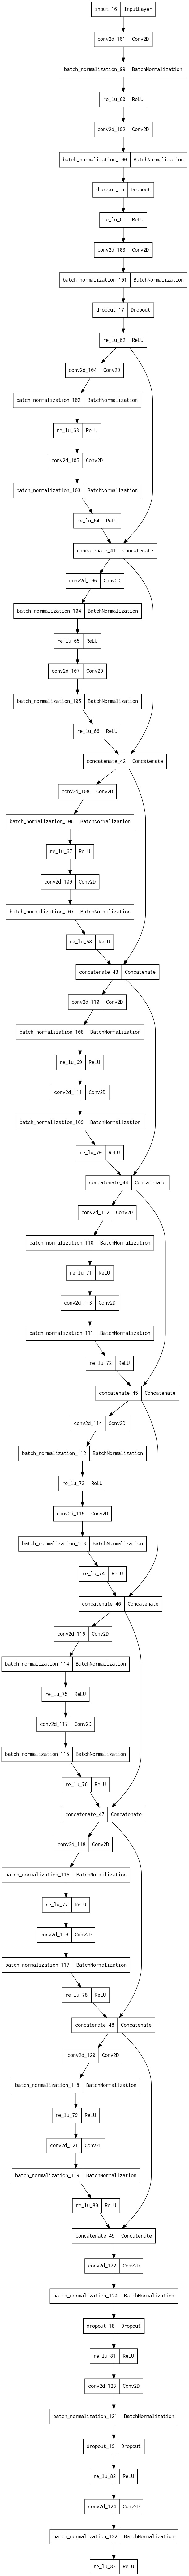

In [29]:
model_gen = build_generator(latent_dim=(256,256,1))
plot_model(model_gen)

We keep an image buffer that stores 50 previously generated images.

In [ ]:
def adverserial_loss(Dy,DGx):
    disc_loss = tf.reduce_mean((Dy - tf.ones_like(Dy))^2)
    gen_loss = tf.reduce_mean((DGx)^2)
    total_loss = disc_loss + gen_loss

In [ ]:
def cyclic_loss(x,y):
    return mean_absolute_error(F(G(x)),x) + mean_absolute_error(G(F(y)),y)    